# How to prepare a dataset and submit a custom entity in Amazon Comprehend

This notebook covers how to prepare a training dataset for custom entities in Amazon Comprehend

In [19]:
# library imports
import re
import numpy as np
import pandas as pd
import matplotlib
import csv


In this example we will be using the following tweet dataset. https://www.kaggle.com/thoughtvector/customer-support-on-twitter
First lets get our data and process it to our needs

In [21]:
tweets = pd.read_csv('./data/twcs.csv',encoding='utf-8')
print(tweets.shape)
tweets.head()

(2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


<a id='data-wrangling'></a>

## Data Wrangling

This is a very interesting tweet data set, about 3 million tweets, and we have information on the author of the tweets and whether the tweet was a query or a response (the "inbound" column). If the tweet was a query, the response_tweet_id gives the response made by the support team.

It would be interesting to modify this dataframe to get query - response pairs in every row.
The following code, to do just what we want, was pulled from [this kernel](https://www.kaggle.com/soaxelbrooke/first-inbound-and-response-tweets)

In [22]:
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

QnR = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
QnR = QnR[QnR.inbound_y ^ True]
print(f'Data shape: {QnR.shape}')
QnR.head()

Data shape: (794299, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0


In [ ]:
# removing anonymized screen names 
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return ''

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Removing anonymized screen names in X...")
QnR["text_x"] = QnR.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Removing anonymized screen names in Y...")
QnR["text_y"] = QnR.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

In [23]:
#making sure the dataframe contains only the needed columns
QnR = QnR[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]
QnR.head(5)

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
0,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...
1,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...
2,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...
3,115713,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,sprintcare,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...
4,115715,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",sprintcare,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...


## Filter to only telco tweets
In our example, we want to create a custom entity to recognize smartphones devices. Let's filer our dataframe to only incclude the T-Mobile and Sprint tweets.

In [7]:
tweet_telco = QnR[QnR["author_id_y"].isin(["TMobileHelp", "sprintcare"])]

Let's concatenate the question and response into one field.

In [25]:
tweet_telco['text'] = tweet_telco['text_x']+ ' | ' + tweet_telco['text_y']

Let's save our telco tweets as a csv file.

In [28]:

tweet_telco['text'].to_csv('./data/tweet_telco.csv', encoding='utf-8', index=False)


In order to create our dataset we need to provide an entity list for our new class named DEVICE

In [29]:
tweet_telco['match'] = tweet_telco['text'].str.extract(r'(iPhoneX|iphoneX|android|Android|iphone|iPhone)', expand=True)

Let's create out training file with only the records where we have a match.

In [30]:
tweet_telco_final = tweet_telco[tweet_telco['match'].notnull()]


Let's add another column with our class label. This is required part of the Amazon Comprehend training dataset.

In [35]:
tweet_telco_final['Type'] = 'DEVICE'


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's rename our columns to match what Amazon Comprehend training dataset requires.

In [36]:
tweet_telco_final = tweet_telco_final.rename(index=str, columns={"text": "Raw_Text", "match": "Text"})

In [37]:
tweet_telco_final.head()

,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,Raw_Text,Text,Type
1128,116686,Tue Oct 31 23:07:07 +0000 2017,@115911 how much for the iPhone x with the jum...,TMobileHelp,Tue Oct 31 23:08:12 +0000 2017,@116686 We'd love to provide you all the detai...,@115911 how much for the iPhone x with the jum...,iPhone,DEVICE
1247,116751,Sun Nov 26 00:24:32 +0000 2017,So tell me how @115911 can tell me in 2014 tha...,TMobileHelp,Sun Nov 26 00:29:00 +0000 2017,@116751 Ouch! We want you to upgrade at the be...,So tell me how @115911 can tell me in 2014 tha...,iPhone,DEVICE
1249,116753,Sun Nov 26 00:22:53 +0000 2017,@115911 needs to ship phones in inconspicuous ...,TMobileHelp,Sun Nov 26 00:24:15 +0000 2017,"@116753 Adrianne, that's definitely a crazy si...",@115911 needs to ship phones in inconspicuous ...,iPhone,DEVICE
1620,117001,Tue Oct 31 23:12:51 +0000 2017,@sprintcare @115714 thinking about upgrading m...,sprintcare,Tue Oct 31 23:16:16 +0000 2017,@117001 Hey! We would need to see what offers ...,@sprintcare @115714 thinking about upgrading m...,iPhone,DEVICE
1939,117235,Tue Oct 31 18:24:19 +0000 2017,if i would have started a youtube channel year...,TMobileHelp,Tue Oct 31 18:30:35 +0000 2017,"@117235 Hey there! Send us a DM, I'll help you...",if i would have started a youtube channel year...,iphoneX,DEVICE


Let's create a training file

In [38]:
tweet_telco_final['Raw_Text'].head(10000).to_csv('./data/raw_txt.csv', encoding='utf-8', index=False)


Let's create the entity list file

In [39]:
tweet_telco_final[['Text', 'Type']].head(10000).to_csv('./data/entity_list.csv', encoding='utf-8', index=False)


Let's create a test file.

In [41]:
tweet_telco['text'].tail(10000).to_csv('./data/telco_device_test.csv', encoding='utf-8', index=False)

## Training our model

I am going to use the console to submit my training job.

My custome entity configuration looks like this.

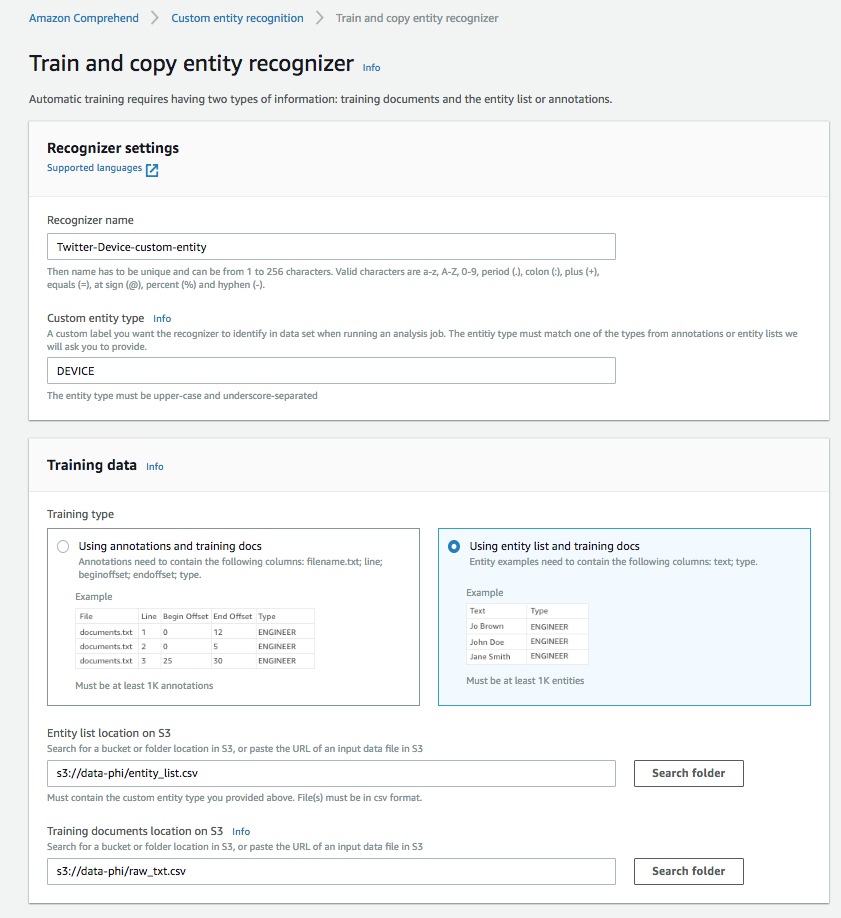

## Testing our custom entity model

Let's invoke the Comprehend API to run our test job from the test file we prepared earlier.

In [ ]:
aws comprehend start-entities-detection-job \
     --entity-recognizer-arn "arn:aws:comprehend:us-east-1:202860692096:entity-recognizer/Twitter-Device-copy" \
     --job-name Test \
     --data-access-role-arn "arn:aws:iam::202860692096:role/service-role/AmazonComprehendServiceRole-AmazonComprehendServiceRole" \
     --language-code en \
     --input-data-config "S3Uri=s3://data-phi/telco_device_test.csv" \
     --output-data-config "S3Uri=s3://data-phi/telco_device_test.json" \
     --region "us-east-1"

The output will be a json file specified in my --output-data-config.
I am going to use Glue and Athena to inspect our results.

Here are the results for hte following query.

"SELECT col3, count(col3) FROM "comprehend"."telco_device_test_json" group by col3;"

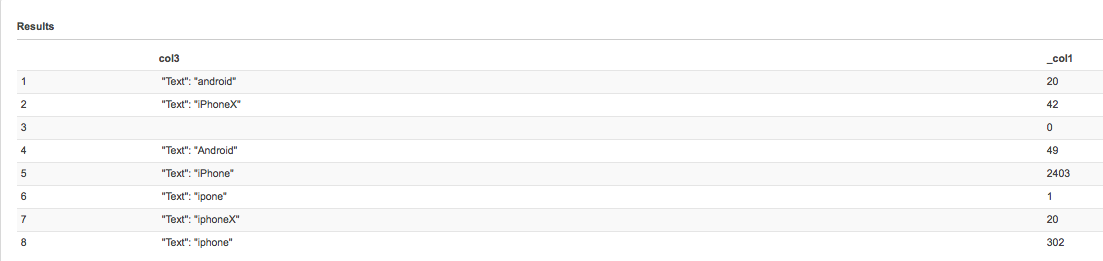


Note that "ipone" was not part of the list of term we used to tag our dataset but our comprehend was able to pick with a certain number of confidence.